# Exploration of tokens obtained by sample encoding

Loading the .pkl files (dictionary {"Token" : NumberOfOccurancesInTheSampleFile}) created in the Ecode_generare_pkl.ipynb

TODO: 
- simplify BPE and BLBPE dicts generation
- load to a dataframe and display most prevalent tokens
- boxplot and histogram of k-mer lengths


entropie:
https://towardsdatascience.com/the-intuition-behind-shannons-entropy-e74820fe9800

In [1]:
import os
print(os.getcwd())

/home/lieberze/DP/Thesis/02_tokenizery_new_data


## Functions

SaveDicts() - generates dictionary of dictionaries. For each tokenizer type, internal dictionaries are dictionaries of tokens for different vocabulary sizes. These consist of 3 additional dictionaries - containing exon, intron and intergenic tokens.

In [2]:
import pickle
def SaveDicts(Paths, VocabSizes, Names):    
    def LoadDicts(FilePath, Names):
        DictOfDicts = {}
        for Name in Names:
            Dict = pickle.load(open(f"{FilePath}/{Name}.pkl", 'rb'))
            DictOfDicts[Name] = Dict
        return DictOfDicts
    
    Dicts = []
    for Path in Paths:
        Dict = {}
        for Size in VocabSizes:
            FilePath = f"{Path}/{Size}"
            Dict[Size] = LoadDicts(FilePath, Names)
        Dicts.append(Dict)
    return Dicts

In [3]:
def Normalize(Dict, target=1.0):
    raw = sum(Dict.values())
    factor = target/raw
    return {key:value*factor for key,value in Dict.items()}

In [4]:
def SortDict(Dict, Ascending):
    if Ascending == True:
        Reverse=False
    else:
        Reverse=True
    Dict = {k: v for k, v in sorted(Dict.items(), key=lambda item: item[1], reverse=Reverse)}    
    return Dict

In [98]:
def ShowTable(Data, VocabSize, N_max, MaxTokenLen, Ascending):   
    
    def SplitByLength(Dict, MaxTokenLen):
        LessThanMaxLen = {}
        EqualToOrMoreThanMax = {}

        for Token, Value in Dict.items():
            if len(Token) >= MaxTokenLen:
                EqualToOrMoreThanMax[Token] = Value
            else:
                LessThanMaxLen[Token] = Value
        return EqualToOrMoreThanMax, LessThanMaxLen

    Data = Data.get(VocabSize)
    ListsForSequenceTypes = []
            
    for ColumnPrefix, Dict in Data.items():  
        Dict = SortDict(Dict, Ascending)
        EqualToOrMore, LessThan = SplitByLength(Dict, MaxTokenLen)
        EqualToOrMore = Normalize(EqualToOrMore)

        d1 = list(EqualToOrMore.keys())[:N_max]
        d2 = list(EqualToOrMore.values())[:N_max] 
        vocab = [VocabSize] * N_max
        result = pd.DataFrame({"size":vocab, f"{ColumnPrefix}_tokens":d1,f"{ColumnPrefix}_reps":d2})
        ListsForSequenceTypes.append(result)
    return ListsForSequenceTypes

In [6]:
# unpacks list of lists into a single flat simple list
def flatten(t):
    return [item for sublist in t for item in sublist]

In [7]:
def RemoveSpecificTokensForAll(DictOfDicts, Symbol):
    def RemoveSpecificTokens(Dict, Symbol):
        Good, Removed = {}, {}
        for k, v in Dict.items():
            if Symbol in k:
                Removed[k] = v
            else:
                Good[k] = v
        return Good, Removed
    
    VocabSizes = [5000, 15000, 50000]
    Names = ["exons", "introns", "intergenic"]

    All_good = {}
    All_removed = {}
    for Size in VocabSizes:
        Sizes_x = {}
        Removed_x = {}
        for Name in Names:
            dictionary = DictOfDicts.get(Size).get(Name)
            Good, Removed = RemoveSpecificTokens(dictionary, Symbol)    
            Sizes_x[Name] = Good
            Removed_x[Name] = Removed
        All_good[Size] = Sizes_x
        All_removed[Size] = Removed_x
        
    return All_good, All_removed

### GC content of  sample file

In [8]:
def UpdateCount(List, A_count, C_count, T_count, G_count):
    A, C, T, G = List
    A += A_count
    C += C_count
    T += T_count
    G += G_count
    return [A, T, C, G]

In [9]:
def ConvertToDict(Dict):
    A, T, C, G = Dict
    Dict = {"A":A, "T":T, "C":C, "G":G}
    return Dict

In [10]:
import pandas as pd
def CreateColumn(Dict, Name):
    Dict = pd.DataFrame(Dict, index=[0])
    Dict["GC"] = Dict.apply(lambda x: x.G + x.C, axis=1)
    Dict = Dict.T
    Dict.columns = [Name]
    return Dict

In [11]:
def CreateDf(Exons, Introns, Intergenic):
    Ex = CreateColumn(Exons, "Exons")
    Intr = CreateColumn(Introns, "Introns")
    Inter = CreateColumn(Intergenic, "Intergenic")

    Ex = Ex.join(Intr, on=None, how='left')
    return Ex.join(Inter, on=None, how='left').T

In [12]:
RootFolder = "/home/lieberze/DP/Thesis/02_tokenizery_new_data/"
DataFolder = os.path.abspath(os.path.join(RootFolder, 'data/sample/'))

Test_folder = os.path.abspath(os.path.join(DataFolder, 'Encoding/'))
File_to_work_with = os.path.abspath(os.path.join(Test_folder, 'All_100k.txt'))

In [ ]:
! cat $File_to_work_with | cut -f1 | sort | uniq -c

### GC content of the sample file

In [13]:
Exon, Intron, Intergenic = [0,0,0,0], [0,0,0,0], [0,0,0,0]

with open(File_to_work_with, "r") as file:
    for line in file:
        LineSplit = line.strip().split()
        Seqtype, Seq = LineSplit[0], LineSplit[-1]
        
        A_count = Seq.lower().count("a")
        C_count = Seq.lower().count("c")
        T_count = Seq.lower().count("t")
        G_count = Seq.lower().count("g") 
        
        if Seqtype == "exon":
            Exon = UpdateCount(Exon, A_count, C_count, T_count, G_count) 
        elif Seqtype == "intron":
            Intron = UpdateCount(Intron, A_count, C_count, T_count, G_count) 
        elif Seqtype == "intergenic":
            Intergenic = UpdateCount(Intergenic, A_count, C_count, T_count, G_count) 

Exon = Normalize(ConvertToDict(Exon), target = 1.0)
Intron = Normalize(ConvertToDict(Intron), target = 1.0)
Intergenic = Normalize(ConvertToDict(Intergenic), target = 1.0)

df = CreateDf(Exon, Intron, Intergenic)
df.to_excel("sample_nucleotide_content_statistics.xlsx")
df

,A,T,C,G,GC
Exons,0.254170,0.250275,0.249787,0.245768,0.495555
Introns,0.288942,0.250283,0.250268,0.210507,0.460775
Intergenic,0.293483,0.249818,0.250386,0.206313,0.456699


### Most used tokens

####  BPE

Function to get dataframes

In [14]:
def GetDataFrames(DictOfTokenDicts, VocabSizes, N_max, MaxLength, Ascending):
    DataFrames = []
    for Size in VocabSizes:
        All = ShowTable(DictOfTokenDicts, Size, N_max, MaxLength,  Ascending)
        All = pd.concat(All, axis=1).add_suffix(f'_{int(Size/1000)}k')
        All = All.loc[:, ~All.columns.duplicated()]
        DataFrames.append(All)
    return DataFrames

In [15]:
def ShowTokenTableAllVocabSizes(ListOfDataFrames, ShowReps=False):
    df = pd.concat(ListOfDataFrames, axis = 1)
    df = df[df.columns.drop(list(df.filter(regex='size')))]
    disiredOrder = df.columns
    exons = [x for x in df.columns if x.startswith("exon")]
    introns = [x for x in df.columns if x.startswith("introns")]
    intergenic = [x for x in df.columns if x.startswith("intergenic")]
    disiredOrder = flatten([exons, introns, intergenic])
    df = df[disiredOrder]
    # filter out the "reps" columns 
    if ShowReps==False:
        df = df[df.columns.drop(list(df.filter(regex='reps')))]
    return df

### Plots

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def ShowBoxplot(Dict, Name, Ax, MinCount=0, MaxCount=np.inf):
    data = [len(x) for x in Dict.keys()]
    data = [x for x in data if (x < MaxCount) & (x > MinCount)]
    data = pd.DataFrame({Name:data})
    x = sns.boxplot(data=data, ax=Ax)
    x.set(xticklabels=[]) 
    return x

## All genomes 41.6 MB sample (all equal)

### Paths

In [17]:
import os
FolderName = "All_genomes_sample"

RootFolder = ""
DataFolder = os.path.abspath(os.path.join(RootFolder, 'data/sample/'))

name = "01_CharBPE"
CharBPE = os.path.abspath(os.path.join(RootFolder, f'{name}/{FolderName}'))
All_512_BPE = os.path.abspath(os.path.join(CharBPE, 'All_512/'))
# All_1000_BPE = os.path.abspath(os.path.join(CharBPE, 'All_1000/'))

name = "02_ByteLevelBPE"
ByteLevelBPE = os.path.abspath(os.path.join(RootFolder, f'{name}/{FolderName}'))
All_512_BLBPE = os.path.abspath(os.path.join(ByteLevelBPE, 'All_512/'))
# All_1000_BLBPE = os.path.abspath(os.path.join(ByteLevelBPE, 'All_1000/'))

### Load dicts

##### BPE

In [18]:
Paths = [All_512_BPE]
VocabSizes = [5000, 15000, 50000]
Names = ["exons", "introns", "intergenic"]

All_512_BPE_tokens = SaveDicts(Paths, VocabSizes, Names)

# Only for BPE (has the </w> token suffix)
All_512_BPE_tokens, _ = Good, Removed = RemoveSpecificTokensForAll(All_512_BPE_tokens[0], "<")

##### BLBPE

In [19]:
Paths = [All_512_BLBPE]
VocabSizes = [5000, 15000, 50000]
Names = ["exons", "introns", "intergenic"]

All_512_BLBPE_tokens = SaveDicts(Paths, VocabSizes, Names)

### Most used tokens

####  BPE

**top 5**

In [21]:
# List_512_BPE = GetDataFrames(All_512_BPE_tokens, [5000, 15000, 50000], 10, 7, Ascending=False)
# BPE_512 = ShowTokenTableAllVocabSizes(List_512_BPE)
# BPE_512

When excluding all smaller than 6, we can better observe the difference in case of the token's letters. Corresponding with the idea that soft-masked positions should occur in introns/intergenic more (or exclusively)

In [ ]:
# All_BPE_50k_2 = ShowTable(All_512_BPE_tokens, 50000, 5, 7, Ascending=False)
# BPE_8500 = ShowTokenTableAllVocabSizes(List_512_BPE)
# pd.concat(All_BPE_50k_2, axis=1)

**bottom 5**

In [ ]:
List_512_BPE = GetDataFrames(All_512_BPE_tokens, [5000, 15000, 50000], 5, 7, Ascending=True)
BPE_512 = ShowTokenTableAllVocabSizes(List_512_BPE)
BPE_512

#### BLBPE

**top**

In [ ]:
List_512_BLBPE = GetDataFrames(All_512_BLBPE_tokens[0], [15000], 10, 7, Ascending=False)
BLBPE_512 = ShowTokenTableAllVocabSizes(List_512_BLBPE)
BLBPE_512

**bottom 5**

In [ ]:
List_512_BLBPE = GetDataFrames(All_512_BLBPE_tokens[0], [5000, 15000, 50000], 15, 7, Ascending=True)
BLBPE_512 = ShowTokenTableAllVocabSizes(List_512_BLBPE)
BLBPE_512

### Plots

In [ ]:
def BoxplotsForAll(Dictionary, Names, Sizes):
    for Size in Sizes:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10,3], sharey=True)
        for Name, ax in zip(Names,[ax1, ax2, ax3]):
            Dict = Dictionary.get(Size).get(Name)
            x = ShowBoxplot(Dict, Name, ax)
            x.set_xlabel(Name)
        fig.suptitle(Size, fontsize=16)

In [ ]:
Names = ["exons", "introns", "intergenic"]
Sizes = [5000, 15000, 50000]
Dictionary = All_512_BPE_tokens

BoxplotsForAll(Dictionary, Names, Sizes)

In [ ]:
Names = ["exons", "introns", "intergenic"]
Sizes = [5000, 15000, 50000]
Dictionary = All_512_BLBPE_tokens[0]

BoxplotsForAll(Dictionary, Names, Sizes)

### Statistic of k-mer lengths

In [ ]:
# https://stackoverflow.com/questions/42017049/seaborn-how-to-add-error-bars-on-a-grouped-barplot
# @ImportanceOfBeingErnest
# modified by @Liebelife

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def grouped_errplot(df, cat, subcat, val, err, y_label, titlename):
    plt.style.use('seaborn-deep')
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.errorbar(x+offsets[i], dfg[val].values,
                label="{} {}".format(subcat, gr), yerr=dfg[err].values, fmt="o", capsize=5)
    plt.xlabel(cat)
    plt.ylabel(y_label) # val
    plt.xticks(x, u)
    plt.legend()
    plt.title(titlename)
    plt.savefig(f'Token_length_{titlename}_{cat}.png')
    plt.show()

In [ ]:
def ShowErrplotsForDict(DictOfDicts, x_axis, titlename): # x_axis either "size" od "type"
    VocabSizes = [5000, 15000, 50000]
    Names = ["exons", "introns", "intergenic"]
    DictOfDicts = DictOfDicts

    Dict_of_describes = {}
    for Name in Names:
        for Size in VocabSizes:
            keys = DictOfDicts.get(Size).get(Name).keys()
            key_lens = [len(x) for x in keys]
            descr = pd.DataFrame(key_lens).describe()
            Dict_of_describes[f"{Name}_{int(Size/1000)}_k"] = descr

    columns = Dict_of_describes.keys()
    vals = Dict_of_describes.values()
    df = pd.concat(vals, axis = 1)
    df.columns = columns
    df = df.T
    df["sequence type"] = df.apply(lambda x: x.name.split("_")[0], axis = 1)
    df["vocab size"] = df.apply(lambda x: x.name.split("_")[1] + "k", axis = 1)

    if x_axis == "size":
        subcat = "sequence type"
        cat = "vocab size"
    elif x_axis == "type":
        cat = "sequence type"
        subcat = "vocab size"
    val = "mean"
    err = "std"
    y_label = "token length"
    titlename=titlename
    plot = grouped_errplot(df, cat, subcat, val, err, y_label,titlename)
    
    return plot

In [22]:
ListOfDictsOfDicts = [["CharBPE", All_512_BPE_tokens], 
                      ["ByteLevelBPE", All_512_BLBPE_tokens[0]]]

for DofD in ListOfDictsOfDicts:
    titlename = DofD[0]
    print(titlename)
    ShowErrplotsForDict(DofD[1], "size", titlename)
    ShowErrplotsForDict(DofD[1], "type", titlename)

CharBPE


NameError: name 'ShowErrplotsForDict' is not defined

### Outlier k-mer exploration

In [153]:
def ShowDf(Dict, Name, MinCount=0, MaxCount=np.inf):
    data = [[len(k),k, v] for k, v in Dict.items()]
    lengths = [x[0] for x in data if (x[0] < MaxCount) & (x[0] > MinCount)]
    tokens = [x[1] for x in data if (x[0] < MaxCount) & (x[0] > MinCount)]
    reps = [x[2] for x in data if (x[0] < MaxCount) & (x[0] > MinCount)]
    data = pd.DataFrame({"tokens":tokens, "lengths":lengths, "reps":reps})
    return data

In [154]:
def GetLenStats(DictOfDicts):
    VocabSizes = [5000, 15000, 50000]
    Names = ["exons", "introns", "intergenic"]

    New_dict = {}
    for Size in VocabSizes:
        Sizes_x = {}
        for Name in Names:
            Dict = DictOfDicts.get(Size).get(Name)
            x = ShowDf(Dict, Name)
            Sizes_x[Name] = x
        New_dict[Size] = Sizes_x
    return New_dict

In [155]:
def DescribeKmerLens(DictOfDicts):
    DataFrames = []
    VocabSizes = [5000, 15000, 50000]
    Names = ["exons", "introns", "intergenic"]
    DictOfDicts = GetLenStats(DictOfDicts)
    for Name in Names:
        dict_len = {}
        for Size in VocabSizes:
            describe = DictOfDicts.get(Size).get(Name).lengths.describe()
            dict_len[Size] = describe
        df = pd.DataFrame(dict_len).add_prefix(f"{Name}_")
        DataFrames.append(df)
    return pd.concat(DataFrames, axis= 1)

In [156]:
print("k-mer length stats")
DescribeKmerLens(All_512_BPE_tokens)

k-mer length stats


,exons_5000,exons_15000,exons_50000,introns_5000,introns_15000,introns_50000,intergenic_5000,intergenic_15000,intergenic_50000
count,4940.000000,14777.000000,46917.000000,4941.000000,14875.000000,49355.000000,4941.000000,14875.000000,49308.000000
mean,6.323077,7.353252,8.298485,6.323821,7.392941,8.616817,6.323821,7.392941,8.624888
std,1.595091,2.204674,2.527182,1.595787,2.275148,3.299079,1.595787,2.275148,3.306081
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,6.000000,7.000000,7.000000,6.000000,7.000000,7.000000,6.000000,7.000000,7.000000
50%,6.000000,7.000000,8.000000,6.000000,7.000000,8.000000,6.000000,7.000000,8.000000
75%,7.000000,8.000000,9.000000,7.000000,8.000000,9.000000,7.000000,8.000000,9.000000
max,32.000000,48.000000,64.000000,32.000000,48.000000,75.000000,32.000000,48.000000,75.000000


In [157]:
print("k-mer length stats")
DescribeKmerLens(All_512_BLBPE_tokens[0])

k-mer length stats


,exons_5000,exons_15000,exons_50000,introns_5000,introns_15000,introns_50000,intergenic_5000,intergenic_15000,intergenic_50000
count,4746.000000,14656.000000,47201.000000,4747.000000,14747.000000,49579.000000,4747.000000,14747.000000,49520.000000
mean,6.293510,7.323895,8.263999,6.294291,7.361565,8.566994,6.294291,7.361565,8.574172
std,1.598612,2.195766,2.506007,1.599349,2.263680,3.234418,1.599349,2.263680,3.240053
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,6.000000,7.000000,7.000000,6.000000,7.000000,7.000000,6.000000,7.000000,7.000000
50%,6.000000,7.000000,8.000000,6.000000,7.000000,8.000000,6.000000,7.000000,8.000000
75%,7.000000,8.000000,9.000000,7.000000,8.000000,9.000000,7.000000,8.000000,9.000000
max,32.000000,48.000000,64.000000,32.000000,48.000000,75.000000,32.000000,48.000000,75.000000


In [191]:
df = pd.DataFrame(GetLenStats(All_512_BPE_tokens).get(5000).get("intergenic"))
df["reps_norm"]= Normalize(dict(df.reps)).values()
# display(df[df["lengths"] > 8].sort_values(by="lengths", axis=0, ascending=False))
df_lens = df[df["lengths"] > 10].sort_values(by="reps", axis=0, ascending=False)
df_lens[df_lens["reps"] > 10]

,tokens,lengths,reps,reps_norm
981,tttttttttttt,12,652,0.000182
1233,aaaaaaaaaaaa,12,502,0.000140
1703,tttttttttttttttt,16,326,0.000091
1704,atatatatatatatat,16,325,0.000091
1847,tgtgtgtgtgtgtgtg,16,291,0.000081
1865,acacacacacacacac,16,286,0.000080
1882,aaaaaaaaaaaaaaaa,16,283,0.000079
1964,tgtgtgtgtgtg,12,267,0.000075
2087,ttgcctggagaa,12,249,0.000069
2150,acacacacacac,12,238,0.000066


In [159]:
def ShowLongKmersWithHigRepetitions(DoD, Sizes, Names, MinLen=0, MinReps=0):
    for Size in Sizes:
        for Name in Names:
            df = pd.DataFrame(GetLenStats(DoD).get(Size).get(Name))
            df["reps_norm"]= Normalize(dict(df.reps)).values()
            # display(df[df["lengths"] > 8].sort_values(by="lengths", axis=0, ascending=False))
            df_lens = df[df["lengths"] > MinLen].sort_values(by="reps", axis=0, ascending=False)
            print(Size, Name)
            display(df_lens[:5])
            # display(df_lens[df_lens["reps"] > MinReps])

In [160]:
# ShowLongKmersWithHigRepetitions(All_1000_BPE_tokens, [5000, 15000, 50000], ["exons"], MinLen=15, MinReps=20)

In [161]:
Names = ["exons","introns", "intergenic"] 
Sizes = [5000, 15000, 50000]
ShowLongKmersWithHigRepetitions(All_512_BPE_tokens, Sizes, Names, MinLen=30, MinReps=10)

5000 exons


,tokens,lengths,reps,reps_norm
3708,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,32,104,0.000029
3990,acacacacacacacacacacacacacacacac,32,87,0.000024
4600,tctctctctctctctctctctctctctctctc,32,44,0.000012
4687,agagagagagagagagagagagagagagagag,32,37,0.000010


5000 introns


,tokens,lengths,reps,reps_norm
2251,acacacacacacacacacacacacacacacac,32,222,0.000062
2714,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,32,178,0.000050
3761,tctctctctctctctctctctctctctctctc,32,120,0.000033
3789,agagagagagagagagagagagagagagagag,32,119,0.000033


5000 intergenic


,tokens,lengths,reps,reps_norm
2253,acacacacacacacacacacacacacacacac,32,223,0.000062
2480,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,32,199,0.000056
3549,tctctctctctctctctctctctctctctctc,32,128,0.000036
4195,agagagagagagagagagagagagagagagag,32,98,0.000027


15000 exons


,tokens,lengths,reps,reps_norm
7034,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,32,53,0.000017
8057,tctctctctctctctctctctctctctctctc,32,44,0.000014
8058,acacacacacacacacacacacacacacacac,32,44,0.000014
11059,agagagagagagagagagagagagagagagag,32,26,0.000008
11488,acacacacacacacacacacacacacacacacacacacac,40,23,0.000007


15000 introns


,tokens,lengths,reps,reps_norm
3683,tctctctctctctctctctctctctctctctc,32,120,0.000038
3925,acacacacacacacacacacacacacacacac,32,111,0.000035
4495,agagagagagagagagagagagagagagagag,32,94,0.000030
4529,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,32,93,0.000029
4901,atatatatatatatatatatatatatatatat,32,85,0.000027


15000 intergenic


,tokens,lengths,reps,reps_norm
3486,tctctctctctctctctctctctctctctctc,32,128,0.000041
3758,acacacacacacacacacacacacacacacac,32,118,0.000037
4427,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,32,96,0.000030
4783,atatatatatatatatatatatatatatatat,32,87,0.000028
6006,agagagagagagagagagagagagagagagag,32,67,0.000021


50000 exons


,tokens,lengths,reps,reps_norm
9998,acacacacacacacacacacacacacacacac,32,34,0.000012
10568,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,32,32,0.000011
13703,acacacacacacacacacacacacacacacacacacacac,40,23,0.000008
14305,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,40,22,0.000008
17810,tctctctctctctctctctctctctctctctc,32,17,0.000006


50000 introns


,tokens,lengths,reps,reps_norm
5277,acacacacacacacacacacacacacacacac,32,75,0.000027
6168,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,32,61,0.000022
6598,acacacacacacacacacacacacacacacacacacacac,40,57,0.000020
6984,agagagagagagagagagagagagagagagag,32,53,0.000019
7496,tctctctctctctctctctctctctctctctc,32,49,0.000018


50000 intergenic


,tokens,lengths,reps,reps_norm
4890,acacacacacacacacacacacacacacacac,32,81,0.000029
5709,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,32,67,0.000024
6284,tctctctctctctctctctctctctctctctc,32,60,0.000022
6584,acacacacacacacacacacacacacacacacacacacac,40,56,0.000020
7739,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,40,47,0.000017


In [162]:
Names = ["exons","introns", "intergenic"] 
Sizes = [5000, 15000, 50000]
ShowLongKmersWithHigRepetitions(All_512_BLBPE_tokens[0], Sizes, Names, MinLen=15, MinReps=10)

5000 exons


,tokens,lengths,reps,reps_norm
2461,tttttttttttttttt,16,192,0.000053
2495,aaaaaaaaaaaaaaaa,16,189,0.000052
3038,acacacacacacacac,16,146,0.000040
3098,tgtgtgtgtgtgtgtg,16,142,0.000039
3653,tgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtg,32,104,0.000029


5000 introns


,tokens,lengths,reps,reps_norm
1396,tttttttttttttttt,16,416,0.000115
1567,aaaaaaaaaaaaaaaa,16,358,0.000099
1599,tgtgtgtgtgtgtgtg,16,349,0.000096
1769,atatatatatatatat,16,303,0.000084
1821,acacacacacacacac,16,292,0.000081


5000 intergenic


,tokens,lengths,reps,reps_norm
1700,atatatatatatatat,16,327,0.000090
1705,tttttttttttttttt,16,326,0.000090
1840,tgtgtgtgtgtgtgtg,16,293,0.000081
1876,acacacacacacacac,16,285,0.000079
1885,aaaaaaaaaaaaaaaa,16,284,0.000078


15000 exons


,tokens,lengths,reps,reps_norm
2812,tttttttttttttttt,16,162,0.000050
2903,aaaaaaaaaaaaaaaa,16,156,0.000048
6433,tgtgtgtgtgtgtgtg,16,59,0.000018
6838,acacacacacacacac,16,55,0.000017
6905,acacacacacacacacacacacacacacacac,32,54,0.000017


15000 introns


,tokens,lengths,reps,reps_norm
1599,tttttttttttttttt,16,335,0.000105
1704,aaaaaaaaaaaaaaaa,16,306,0.000096
2748,agagagagagagagag,16,170,0.000053
3021,tctctctctctctctc,16,153,0.000048
3163,acacacacacacacacacacacacacacacac,32,144,0.000045


15000 intergenic


,tokens,lengths,reps,reps_norm
1916,tttttttttttttttt,16,268,0.000084
2029,aaaaaaaaaaaaaaaa,16,251,0.000079
2875,agagagagagagagag,16,160,0.000050
3112,tctctctctctctctc,16,147,0.000046
3223,acacacacacacacacacacacacacacacac,32,140,0.000044


50000 exons


,tokens,lengths,reps,reps_norm
3220,tttttttttttttttt,16,135,0.000047
3703,aaaaaaaaaaaaaaaa,16,113,0.000039
8151,tgtgtgtgtgtgtgtg,16,44,0.000015
8502,acacacacacacacac,16,42,0.000015
9794,acacacacacacacacacacacacacacacac,32,35,0.000012


50000 introns


,tokens,lengths,reps,reps_norm
1741,tttttttttttttttt,16,281,0.000100
2128,aaaaaaaaaaaaaaaa,16,221,0.000078
3662,agagagagagagagag,16,118,0.000042
3794,tgtgtgtgtgtgtgtg,16,113,0.000040
4035,tctctctctctctctc,16,105,0.000037


50000 intergenic


,tokens,lengths,reps,reps_norm
2046,tttttttttttttttt,16,232,0.000083
2490,aaaaaaaaaaaaaaaa,16,183,0.000066
3701,agagagagagagagag,16,116,0.000042
4314,tgtgtgtgtgtgtgtg,16,94,0.000034
4853,acacacacacacacacacacacacacacacac,32,82,0.000029


In [163]:
def SplitByLength(Dict, MaxTokenLen):
    LessThanMaxLen = {}
    EqualToOrMoreThanMax = {}

    for Token, Value in Dict.items():
        if len(Token) >= MaxTokenLen:
            EqualToOrMoreThanMax[Token] = Value
        else:
            LessThanMaxLen[Token] = Value
    return EqualToOrMoreThanMax, LessThanMaxLen

In [164]:
def CheckUpperLowerRatio(Dict, Size, Name, MinTokenLength, TopNTokens):
    dct = Dict.get(Size).get(Name)
    top, _ = SplitByLength(dct, MinTokenLength)
    lst = list(top.keys())[:TopNTokens]
    
    low = 0
    up = 0
    for i in lst:
        for char in i:
            if char.islower():
                low += 1
            else:
                up += 1
    ratio_of_lowercase = low / (low + up)
    return ratio_of_lowercase

In [165]:
# dict_of_lowercase_ratio = {}
for name, Dict in zip(["CharBPE", "ByteLevelBPE"],[All_512_BPE_tokens, All_512_BLBPE_tokens[0]]):
    dict_of_sizes = {}
    for Size in Sizes:
        dict_of_types = {}
        for typ in ["exons", "introns", "intergenic"]:
            ratio_of_lowercase = CheckUpperLowerRatio(Dict, Size, typ, 7, 100)
            # print(name, Size, typ,ratio_of_lowercase)
            dict_of_types[typ] = ratio_of_lowercase
        dict_of_sizes[Size] = dict_of_types
    # dict_of_lowercase_ratio[name] = dict_of_sizes
    print(name)
    df = pd.DataFrame.from_dict(dict_of_sizes)
    df.to_excel(f"{name}_lowercase_ratio.xlsx")
    display(df)
# pd.DataFrame.from_dict(dict_of_lowercase_ratio)

CharBPE


,5000,15000,50000
exons,0.095170,0.072650,0.062678
introns,0.692819,0.588798,0.539095
intergenic,0.867388,0.780952,0.712329


ByteLevelBPE


,5000,15000,50000
exons,0.095170,0.072650,0.062678
introns,0.683511,0.603239,0.519890
intergenic,0.867568,0.771429,0.702740


In [166]:
# All_512_BPE_tokens

In [167]:
# https://onestopdataanalysis.com/shannon-entropy/
import collections
from scipy.stats import entropy
import scipy

def estimate_shannon_entropy(dna_sequence):
    bases = collections.Counter([tmp_base for tmp_base in dna_sequence])
    # define distribution
    dist = [x/sum(bases.values()) for x in bases.values()]
 
    # use scipy to calculate entropy
    entropy_value = scipy.stats.entropy(dist, base=2)
 
    return entropy_value

In [168]:
algorithms = {"ByteLevelBPE":All_512_BLBPE_tokens[0], "CharBPE":All_512_BPE_tokens}

def get_entropies_dict(algorithm):
    BPE_entropies = {}
    Sizes = [5000, 15000, 50000]
    for Size in Sizes:
        entropies_dict = {}
        for Typ in ["exons", "introns", "intergenic"]:
            d = algorithm[Size][Typ]
            entropies = [estimate_shannon_entropy(i) for i in d]
            entropies_dict[Typ] = entropies
        BPE_entropies[Size] = entropies_dict
    return BPE_entropies

In [169]:
for name, dictionary in algorithms.items():
    BPE_entropies = get_entropies_dict(dictionary)
    for Size in Sizes:
        for Typ in ["exons", "introns", "intergenic"]:
            mx = max(BPE_entropies[Size][Typ])
            print(Size, Typ, mx)

5000 exons 2.0
5000 introns 2.0
5000 intergenic 2.0
15000 exons 2.0
15000 introns 2.0
15000 intergenic 2.0
50000 exons 2.584962500721156
50000 introns 2.584962500721156
50000 intergenic 2.584962500721156
5000 exons 2.0
5000 introns 2.0
5000 intergenic 2.0
15000 exons 2.3219280948873626
15000 introns 2.3219280948873626
15000 intergenic 2.3219280948873626
50000 exons 2.584962500721156
50000 introns 2.584962500721156
50000 intergenic 2.584962500721156


In [170]:
THRESHOLD = 1.2
high_entropy = {}

for name, dictionary in algorithms.items():
    entr_dict = get_entropies_dict(dictionary)
    for Size in Sizes:
        entropies_dict = {}
        for Typ in ["exons", "introns", "intergenic"]:
            entr = entr_dict[Size][Typ]
            values = [[value, occurence] for [value, occurence] in dictionary[Size][Typ].items()]
            res = {v[0]:v[1] for [v,e] in zip(values, entr) if e > THRESHOLD}
            entropies_dict[Typ] = res

        high_entropy[Size] = entropies_dict

    print(len(high_entropy[5000]["exons"]), len(dictionary[5000]["exons"]))
    print(name)
    List_512_BPE = GetDataFrames(high_entropy, [5000, 15000, 50000], 5, 7, Ascending=False)
    BPE_512 = ShowTokenTableAllVocabSizes(List_512_BPE)
    display(BPE_512)
    BPE_512.to_excel(f"Top_5_tokens_{name}.xlsx")
    # BPE_512

3641 4746
ByteLevelBPE


,exons_tokens_5k,exons_tokens_15k,exons_tokens_50k,introns_tokens_5k,introns_tokens_15k,introns_tokens_50k,intergenic_tokens_5k,intergenic_tokens_15k,intergenic_tokens_50k
0,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,tggaaaa,ACATTTT,ACATTTT
1,CTGGAGG,CTGGAGG,CTGGAGG,actgagcc,ACATTTT,ACATTTT,aggctcc,tggaaaa,CATTTCC
2,CTCCAGG,CTCCAGG,CTCCAGG,aggctcc,CATTTCC,CATTTCC,actgagcc,CATTTCC,CTCTGGG
3,CTCCTGG,CTCCTGG,CTCCTGG,tggaaaa,CTCTTGG,CTCAGGG,acagagg,atatatg,TCATCTT
4,CTCAGGG,CTCAGGG,CAGGAGG,actgagc,tggaaaa,TCATCTT,ACATTTT,CTCTGGG,atatatg


3810 4940
CharBPE


,exons_tokens_5k,exons_tokens_15k,exons_tokens_50k,introns_tokens_5k,introns_tokens_15k,introns_tokens_50k,intergenic_tokens_5k,intergenic_tokens_15k,intergenic_tokens_50k
0,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,tggaaaa,ACATTTT,ACATTTT
1,CTGGAGG,CTGGAGG,CTGGAGG,actgagcc,ACATTTT,ACATTTT,aggctcc,tggaaaa,CATTTCC
2,CTCCAGG,CTCCAGG,CTCCAGG,aggctcc,CATTTCC,CATTTCC,actgagcc,CATTTCC,TCATCTT
3,CTCCTGG,CTCCTGG,CTCCTGG,tggaaaa,CTCTTGG,CTCAGGG,ACATTTT,atatatg,CTCTGGG
4,CAGGAGG,CAGGAGG,CAGGAGG,actgagc,tggaaaa,TCATCTT,acagagg,CTCTGGG,atatatg


In [171]:
THRESHOLD = 1.2
high_entropy = {}
def get_high_entropy(name, dictionary, THRESHOLD):
    entr_dict = get_entropies_dict(dictionary)
    for Size in Sizes:
        entropies_dict = {}
        for Typ in ["exons", "introns", "intergenic"]:
            entr = entr_dict[Size][Typ]
            values = [[value, occurence] for [value, occurence] in dictionary[Size][Typ].items()]
            res = {v[0]:v[1] for [v,e] in zip(values, entr) if e >= THRESHOLD}
            entropies_dict[Typ] = res
            
        high_entropy[Size] = entropies_dict
    return high_entropy

for name, dictionary in algorithms.items():
    high_entropy = get_high_entropy(name, dictionary, THRESHOLD)
    print(len(high_entropy[5000]["exons"]), len(dictionary[5000]["exons"]))
    print(name)
    List_512_BPE = GetDataFrames(high_entropy, [5000, 15000, 50000], 5, 7, Ascending=False)
    BPE_512 = ShowTokenTableAllVocabSizes(List_512_BPE)
    BPE_512.to_excel(f"Top_5_tokens_{name}.xlsx")
    display(BPE_512)

3641 4746
ByteLevelBPE


,exons_tokens_5k,exons_tokens_15k,exons_tokens_50k,introns_tokens_5k,introns_tokens_15k,introns_tokens_50k,intergenic_tokens_5k,intergenic_tokens_15k,intergenic_tokens_50k
0,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,tggaaaa,ACATTTT,ACATTTT
1,CTGGAGG,CTGGAGG,CTGGAGG,actgagcc,ACATTTT,ACATTTT,aggctcc,tggaaaa,CATTTCC
2,CTCCAGG,CTCCAGG,CTCCAGG,aggctcc,CATTTCC,CATTTCC,actgagcc,CATTTCC,CTCTGGG
3,CTCCTGG,CTCCTGG,CTCCTGG,tggaaaa,CTCTTGG,CTCAGGG,acagagg,atatatg,TCATCTT
4,CTCAGGG,CTCAGGG,CAGGAGG,actgagc,tggaaaa,TCATCTT,ACATTTT,CTCTGGG,atatatg


3810 4940
CharBPE


,exons_tokens_5k,exons_tokens_15k,exons_tokens_50k,introns_tokens_5k,introns_tokens_15k,introns_tokens_50k,intergenic_tokens_5k,intergenic_tokens_15k,intergenic_tokens_50k
0,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,CTCTGGG,tggaaaa,ACATTTT,ACATTTT
1,CTGGAGG,CTGGAGG,CTGGAGG,actgagcc,ACATTTT,ACATTTT,aggctcc,tggaaaa,CATTTCC
2,CTCCAGG,CTCCAGG,CTCCAGG,aggctcc,CATTTCC,CATTTCC,actgagcc,CATTTCC,TCATCTT
3,CTCCTGG,CTCCTGG,CTCCTGG,tggaaaa,CTCTTGG,CTCAGGG,ACATTTT,atatatg,CTCTGGG
4,CAGGAGG,CAGGAGG,CAGGAGG,actgagc,tggaaaa,TCATCTT,acagagg,CTCTGGG,atatatg


In [172]:
THRESHOLD = 1.7
for name, dictionary in algorithms.items():
    high_entropy = get_high_entropy(name, dictionary, THRESHOLD)
    dict_of_sizes = {}
    for Size in Sizes:
        dict_of_types = {}
        for typ in ["exons", "introns", "intergenic"]:
            ratio_of_lowercase = CheckUpperLowerRatio(high_entropy, Size, typ, 7, 100)
            dict_of_types[typ] = ratio_of_lowercase
        dict_of_sizes[Size] = dict_of_types
    df = pd.DataFrame.from_dict(dict_of_sizes)
    df.to_excel(f"{name}_lowercase_ratio_high_entropy.xlsx")
    display(df)
    # break

,5000,15000,50000
exons,0.000000,0.000000,0.000000
introns,0.232068,0.082621,0.051355
intergenic,0.373278,0.142450,0.051355


,5000,15000,50000
exons,0.000000,0.000000,0.000000
introns,0.220028,0.102564,0.051355
intergenic,0.374140,0.154830,0.051355


In [173]:
# # dict_of_lowercase_ratio = {}
# for name, Dict in zip(["CharBPE", "ByteLevelBPE"],[All_512_BPE_tokens, All_512_BLBPE_tokens[0]]):
#     dict_of_sizes = {}
#     for Size in Sizes:
#         dict_of_types = {}
#         for typ in ["exons", "introns", "intergenic"]:
#             ratio_of_lowercase = CheckUpperLowerRatio(Dict, Size, typ, 7, 100)
#             # print(name, Size, typ,ratio_of_lowercase)
#             dict_of_types[typ] = ratio_of_lowercase
#         dict_of_sizes[Size] = dict_of_types
#     # dict_of_lowercase_ratio[name] = dict_of_sizes
#     print(name)
#     df = pd.DataFrame.from_dict(dict_of_sizes)
#     df.to_excel(f"{name}_lowercase_ratio.xlsx")
#     display(df)
# # pd.DataFrame.from_dict(dict_of_lowercase_ratio)

In [174]:
# len(high_entropy[5000]["exons"]), len(All_512_BPE_tokens[5000]["exons"])

In [175]:
# All_512_BPE_tokens

get top 10 tokens longer than 7

In [176]:
List_512_BPE = GetDataFrames(high_entropy, [5000, 15000, 50000], 10, 7, Ascending=False)
BPE_512 = ShowTokenTableAllVocabSizes(List_512_BPE)
BPE_512

,exons_tokens_5k,exons_tokens_15k,exons_tokens_50k,introns_tokens_5k,introns_tokens_15k,introns_tokens_50k,intergenic_tokens_5k,intergenic_tokens_15k,intergenic_tokens_50k
0,CTCCAGG,CTCCAGG,CTCCAGG,actgagcc,CTCAGGG,CTCAGGG,aggctcc,CTCAGGG,CTCAGGG
1,CTCAGGG,CTCAGGG,CTCAGGG,aggctcc,CACTGGG,CACTGGG,actgagcc,CACTGGG,CACTGGG
2,CATCTGG,CATCTGG,CATCTGG,actgagc,CACTCTG,CACTCTG,actgagc,CACTCAG,CATCTTG
3,CACTGGG,CACTGGG,CAGCTGG,tggctcag,CACTCAG,CACTCAG,tggctcag,CATCTTG,CACTCAG
4,CAGCTGG,CAGCTGG,CAGGCTG,CTCAGGG,CATCTGG,CTCAAGG,taagcgc,CACTCTG,TCATCTG
5,CAGGCTG,CAGGCTG,CTGGAAG,CACTGGG,CTCAAGG,TCATCTG,tactggag,acctggg,ACATTTG
6,CTGGAAG,CTGGAAG,CACTGGG,taagcgc,acctggg,CATCTGG,CTCAGGG,CATCTGG,CACTCTG
7,CTCAAGG,CTCAAGG,TCTCCAG,CACTCTG,aggctcc,CTCCAGG,agtattc,actgagcc,CATCTGG
8,CACTCAG,CACTCAG,CTGCAGG,acctggg,CATCTTG,TCTCCAG,acctggg,aggctcc,CTCCAGG
9,TCTCCAG,TCTCCAG,CAGGTCC,CACTCAG,CACTTGG,TCACCTG,taagtgc,tggctcag,TCACATG


In [177]:
# high_entropy

In [178]:
# The maximum possible entropy of an alphabet consisting of N different letters is H = log2 N
np.log2(8)

3.0

In [179]:
estimate_shannon_entropy("atttttcc"), estimate_shannon_entropy("aTtCAcGg")

(1.2987949406953987, 3.0)

In [180]:
estimate_shannon_entropy("CTCGCTCG"), estimate_shannon_entropy("CCCCCCC"), estimate_shannon_entropy("CCccCCC")

(1.5, 0.0, 0.8631205685666311)

In [181]:
from keras.preprocessing.sequence import pad_sequences
path_encoded_file = "/home/lieberze/DP/Thesis/04_baseline/data/test/BLBPE/encoded_3x3.txt"

SeqTypes, Ids = [], []
with open(path_encoded_file, "r") as file:
    for line in file:
        s, i = line.strip().split("\t")
        i = np.array(i.strip("[]").split(", ")).reshape(-1,1)
        SeqTypes.append(s), Ids.append(i)
    X = pad_sequences(Ids, value=1, padding='post')
    nsamples, nx, ny = X.shape
    X = X.reshape((nsamples,nx*ny)) # from 3 to 2 dimensions
    y = np.array(SeqTypes)            

In [182]:
df = pd.DataFrame(X)

In [183]:
from sklearn.preprocessing import StandardScaler
df_st =  StandardScaler().fit_transform(df)  
# pd.DataFrame(df_st, columns=df.columns).head(2)

https://www.reneshbedre.com/blog/principal-component-analysis.html

In [184]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pc = pca.fit_transform(df_st)
pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2','PC3','PC4'])
pc_df['Cluster'] = y
pc_df.head()

,PC1,PC2,PC3,PC4,Cluster
0,-0.569721,0.500059,-0.029725,-0.220205,intron
1,0.313212,-0.954676,1.293134,-0.318347,intron
2,-0.743093,0.911536,-0.610595,0.367925,exon
3,-0.769555,0.816872,-0.557388,0.686243,intergenic
4,-0.651607,0.681073,-0.433533,-0.157440,exon


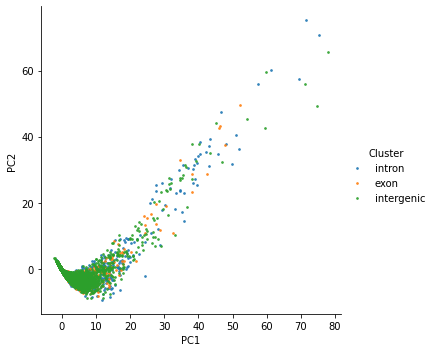

In [185]:
import seaborn as sns
plot = sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 3}) # specify the point size
fig = plot.savefig("pca.png")

In [186]:
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.016s...


KeyboardInterrupt: 

In [ ]:
df_subset = pd.DataFrame(X, y).reset_index()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(6,6))
plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="index",
    palette=sns.color_palette("hls", 3),
    data=df_subset,
    legend="full",
    alpha=0.3
)
fig = plot.figure.savefig("tsne.png")